 # 0.0 IMPORTAÇÕES E FUNÇÕES DE AJUDA


In [288]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [289]:
df_raw = pd.read_csv('data\cardio_train.csv', sep=';')
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# 1.0 DESCRIÇÃO DOS DADOS

In [290]:
df1 = df_raw.copy()

## 1.1 Tamanho do DataSet

In [291]:
print(f'Números de linhas: {df1.shape[0]}')
print(f'Números de colunas: {df1.shape[1]}')

Números de linhas: 70000
Números de colunas: 13


## 1.2 Nomes das Colunas

In [292]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## 1.3 Tipos de Dados

In [293]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.4 Check NA

In [294]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.5 Estatística Descritiva

In [295]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [296]:
# Tendencia Central - Media e Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Despesão - Desvio Padrão, Mínimo, Máximo, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
2,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
5,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
6,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.283482,2.905867,6.444250


# 2.0 FEATURE ENGENEERING

In [297]:
df2 = df1.copy()

In [298]:
# Criando a variável ano de nascimento.
df2['born_year'] = df2['age'].apply(lambda x: (dt.datetime.today() - dt.timedelta(days=x)).year)

# Criando coluna IMC
df2['imc'] = df2.apply(lambda x: x['weight'] / (x['height']/100)**2, axis=1)

# Trocando os valores da variável gender de 1-2 para 0-1
df2['gender'] = df2['gender'].apply(lambda x: 0 if x == 2 else 1)


# 3.0 FILTRAGEM DE DADOS

In [299]:
df3 = df2.copy()

In [300]:
# Removendo inconsistencias na pressão.
for i in range(len(df3)):
    if df3.loc[i, 'ap_hi'] < df3.loc[i, 'ap_lo']:
        df3 = df3.drop(i)

# Removendo inconsistencias na altura.
df3 = df3[df3['height'] > 130]
df3 = df3[df3['height'] < 210]

# Removendo inconsistencias na variável peso.
df3 = df3[df3['weight'] > 45]

# Removendo inconsistencias na pressão.
df3 = df3[df3['ap_lo'] > 50]
df3 = df3[df3['ap_lo'] < 170]
df3 = df3[df3['ap_hi'] > 80]
df3 = df3[df3['ap_hi'] < 210]


# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [301]:
df4 = df3.copy()

## 4.1 Análise Univariada

## 4.2 Análise Bivariada

1 - Pessoas com mais idade, em média tem mais propenção a ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

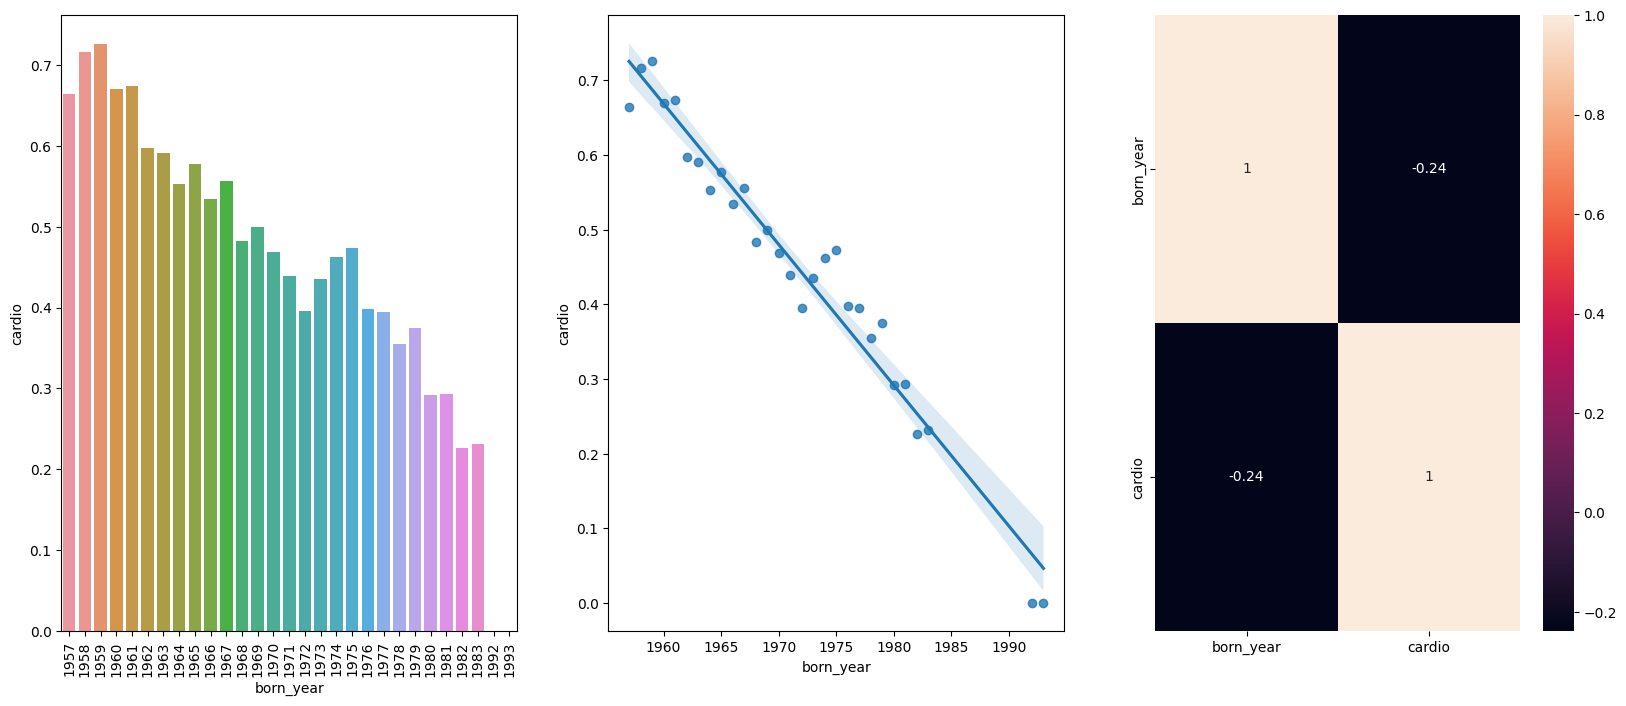

In [307]:
aux = df4[['born_year', 'cardio']].groupby('born_year').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='born_year', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='born_year', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['born_year', 'cardio']].corr(method='pearson'), annot=True)

2 - Homens e Mulheres tem em média chances diferentes de sofrer um ataque cardiaco. (Falso!)

In [311]:
df4[['gender', 'cardio']].groupby('gender').mean().reset_index()

,gender,cardio
0,0,0.499811
1,1,0.494261


3 - Altura não aumenta as chances de ataque cardiaco. (Verdadeiro)

<AxesSubplot:>

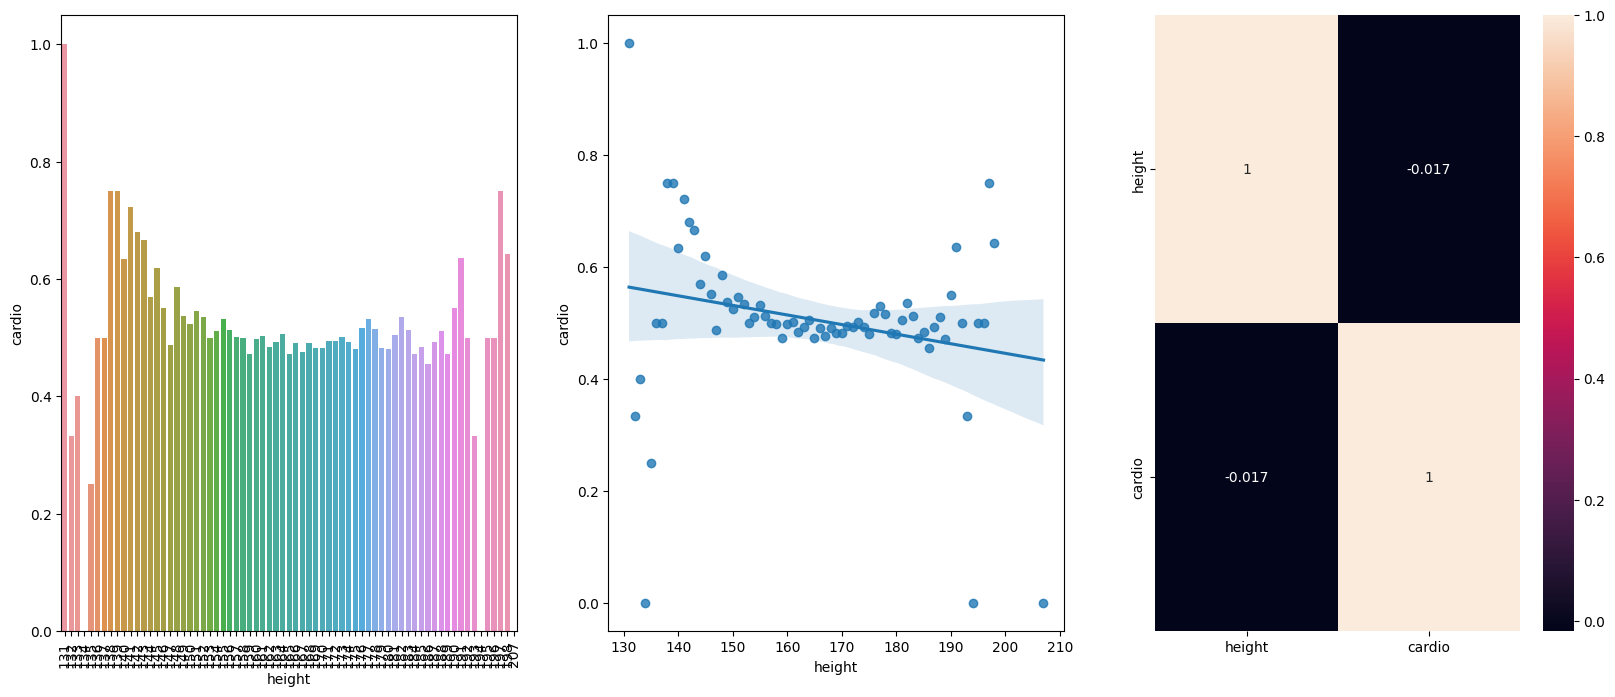

In [315]:
aux = df4[['height', 'cardio']].groupby('height').mean().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='height', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='height', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['height', 'cardio']].corr(method='pearson'), annot=True)

4 - Quando maior o peso da pessoa, maior a chance de ela ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

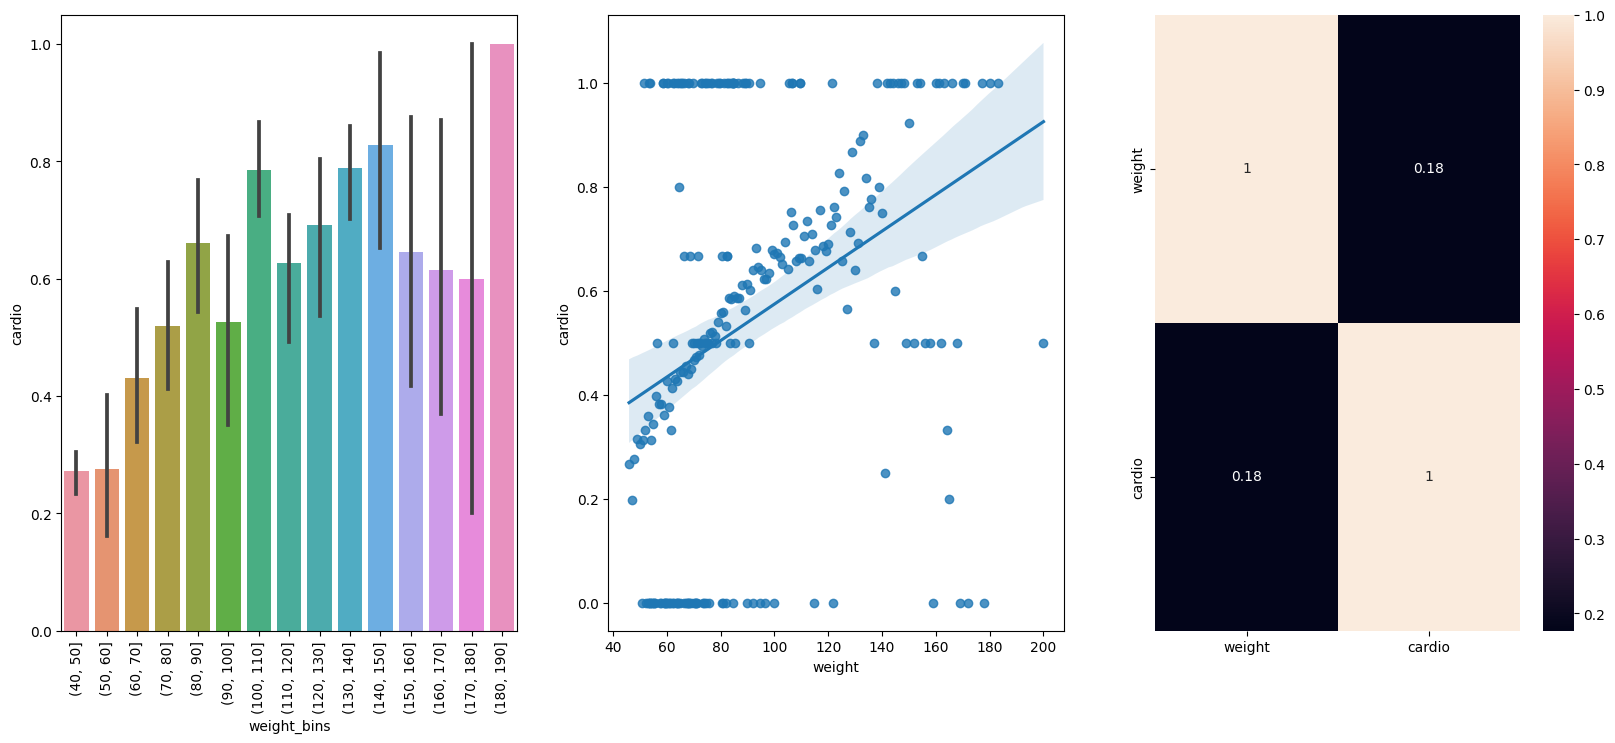

In [327]:
aux = df4[['weight', 'cardio']].groupby('weight').mean().reset_index()


bins = list(np.arange(40,200, 10))

aux['weight_bins'] = pd.cut(aux['weight'], bins=bins)
aux1 = aux[['weight_bins', 'cardio']].groupby('weight_bins').sum().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='weight_bins', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='weight', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['weight', 'cardio']].corr(method='pearson'), annot=True)

10 - Pessoas com imc maior, em média tem mais propenção a ter um ataque cardiaco. (Verdadeiro!)

<AxesSubplot:>

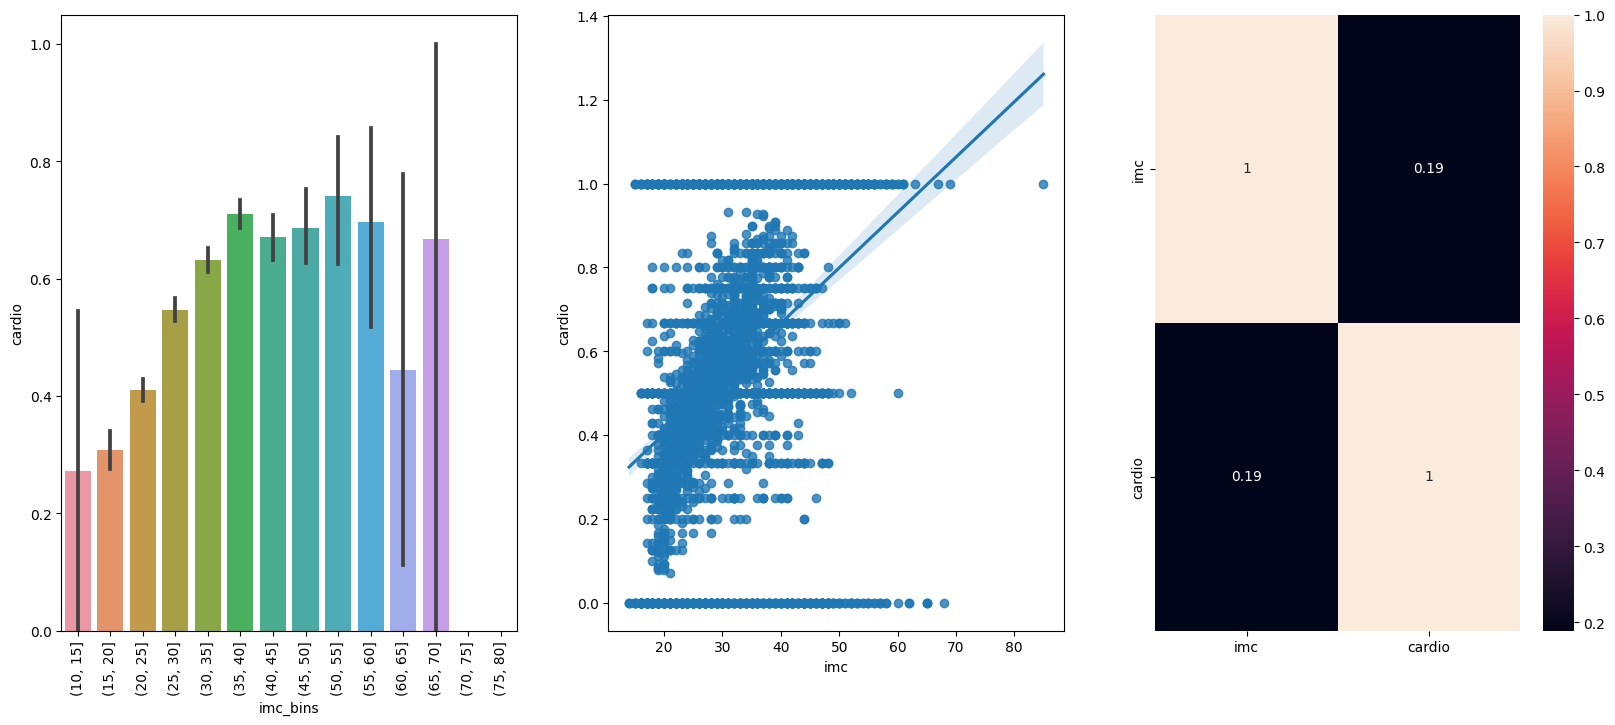

In [329]:
aux = df4[['imc', 'cardio']].groupby('imc').mean().reset_index()
aux['imc'] = np.int64(aux['imc'])

bins = list(np.arange(10,85, 5))

aux['imc_bins'] = pd.cut(aux['imc'], bins=bins)
aux1 = aux[['imc_bins', 'cardio']].groupby('imc_bins').sum().reset_index()

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.barplot(x='imc_bins', y='cardio', data=aux)
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.regplot(x='imc', y='cardio', data=aux)
plt.subplot(1,3,3)
sns.heatmap(df4[['imc', 'cardio']].corr(method='pearson'), annot=True)

In [322]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

# Tendencia Central - Media e Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Despesão - Desvio Padrão, Mínimo, Máximo, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.000000,99999.000000,99999.000000,49952.646167,49976.500000,28848.118917,-0.000470,-1.198228
1,age,10798.000000,23713.000000,12915.000000,19467.922261,19702.000000,2465.715830,-0.306437,-0.821938
2,gender,0.000000,1.000000,1.000000,0.649726,1.000000,0.477056,-0.627724,-1.606009
3,height,131.000000,207.000000,76.000000,164.512223,165.000000,7.792281,0.138085,0.142384
4,weight,46.000000,200.000000,154.000000,74.309403,72.000000,14.105390,1.063809,2.482484
5,ap_hi,85.000000,202.000000,117.000000,126.734717,120.000000,16.401839,0.880666,1.306216
6,ap_lo,52.000000,160.000000,108.000000,81.370381,80.000000,9.284011,0.341586,1.415128
7,cholesterol,1.000000,3.000000,2.000000,1.365056,1.000000,0.679505,1.595428,1.018823
8,gluc,1.000000,3.000000,2.000000,1.226186,1.000000,0.572227,2.399978,4.304486
9,smoke,0.000000,1.000000,1.000000,0.088183,0.000000,0.283560,2.904686,6.437389
